In [23]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Matplotlib is building the font cache; this may take a moment.


In [56]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/chandan/embedded-ngrams'
dir_names = sorted([fname
                    for fname in os.listdir(out_dir)
                    if os.path.isdir(oj(out_dir, fname))
                   ])
# print(dir_names)

results_list = [pd.Series(pkl.load(open(oj(out_dir, dir_name, 'results.pkl'), "rb")))
                for dir_name in tqdm(dir_names)]
r = pd.concat(results_list, axis=1).T.infer_objects().drop(columns='model')

100%|██████████| 73/73 [00:01<00:00, 71.47it/s]


In [57]:
r = r.fillna('')
r['all'] = r['all'].replace('True', 'all')

In [58]:
(
    r.sort_values(by=['subsample', 'acc_val'], ascending=False)
#     .fillna('')
#     .replace('', False)
)

,checkpoint,ngrams,subsample,padding,num_features,acc_train,acc_val,all,norm
55,bert-base-uncased,5,1000,True,768,0.750000,0.767202,,
67,bert-base-uncased,7,1000,True,768,0.743000,0.764908,,
56,bert-base-uncased,5,1000,True,768,0.915000,0.753440,all,
44,bert-base-uncased,4,1000,True,768,0.907000,0.747706,all,
57,bert-base-uncased,5,1000,True,768,0.901000,0.746560,all,norm
21,bert-base-uncased,2,1000,True,768,0.793000,0.745413,all,norm
43,bert-base-uncased,4,1000,True,768,0.763000,0.743119,,
45,bert-base-uncased,4,1000,True,768,0.887000,0.739679,all,norm
19,bert-base-uncased,2,1000,True,768,0.827000,0.738532,,
31,bert-base-uncased,3,1000,True,768,0.834000,0.737385,,


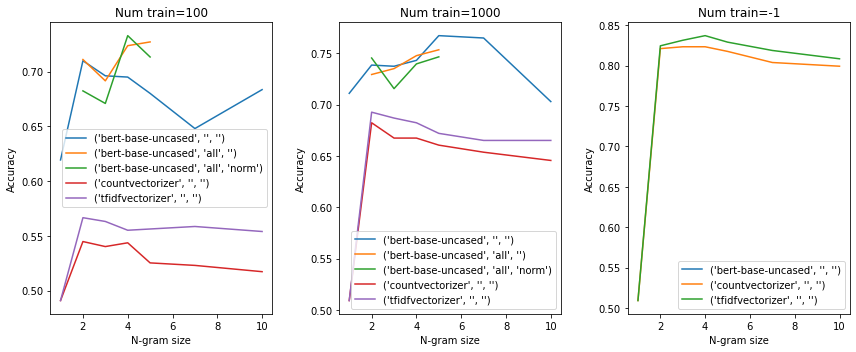

In [61]:
C = 3
plt.figure(figsize=(12, 5))
for i, subsample in enumerate([100, 1000, -1]):
    plt.subplot(1, C, i + 1)
    plt.title('Num train=' + str(subsample))
    d = r[r.subsample == subsample]
    
    curve = d.groupby(['checkpoint', 'all', 'norm'])
    for key, group in curve:
        g = group.sort_values('ngrams')
        plt.plot(g.ngrams, g.acc_val, label=key)
    plt.ylabel('Accuracy')
    plt.xlabel('N-gram size')

    
    plt.legend()
    
plt.tight_layout()
plt.savefig('results/acc_by_ngrams_sst.pdf')
#     print(curve)